# Autograd

## Creating `isQ` Code

In general quantum circuit simulations, we recommend using `sample=False`. This simulation method yields exact measurement results of the quantum circuit (i.e., theoretical probability distributions), without concerns about the number of shots. The exact simulation result corresponds to the limit as the number of shots approaches infinity.

When using exact simulation, another benefit is the ability to compute gradients of parameters analytically by using the `AutogradBackend` or `TorchBackend`. First, we construct a quantum circuit that contains parameters `params[]`.

This piece of code should be named `gradient.isq` and placed in the same directory.

```c++
import std;


param params[];
qbit q[1];

unit main() {
    Ry(params[0], q[0]);
    Rx(params[1], q[0]);
    M(q[0]);
}
```

We use `tempfile`to simulate here.

In [1]:
FILE_CONTENT = """\
import std;


param params[];
qbit q[1];

unit main() {
    Ry(params[0], q[0]);
    Rx(params[1], q[0]);
    M(q[0]);
}"""

## Automatic Differentiation with Autograd

Autograd, a lightweight extension of NumPy, can be used to perform automatic differentiation. First, we use `AutogradBackend` as the simulation backend and set `sample=False` to obtain exact simulation results. Then, we define a NumPy array `params1` and a function `circuit1`.

Within the function, we call `qc1.measure(params=params1)`, passing our parameters as a keyword argument. Here, the left side of `params=params1` corresponds to the parameter definition in `gradient.isq`, while the right side refers to the `params1 `array defined in Python. The return value of the function `circuit1` is the first element of the measurement result array, i.e., `results[0]`.

In [2]:
import tempfile
from pathlib import Path

import numpy as np
from isqtools import IsqCircuit
from isqtools.backend import AutogradBackend, TorchBackend

with tempfile.TemporaryDirectory() as temp_dir:
    temp_dir_path = Path(temp_dir)
    temp_file_path = temp_dir_path / "gradient.isq"
    with open(temp_file_path, "w") as temp_file:
        temp_file.write(FILE_CONTENT)

    autograd_backend = AutogradBackend()

    qc1 = IsqCircuit(
        file=str(temp_file_path),
        backend=autograd_backend,
        sample=False,
    )

    params1 = np.array([0.9, 1.2])

    def circuit1(params1):
        results = qc1.measure(params=params1)
        return results[0]

    print(circuit1(params1))

0.6126225961314372


At this point, we can use the `grad` function from Autograd to compute the derivative of the `circuit1` function. The `grad` function accepts the index of the parameter to differentiate with respect to as its second argument. In this case, since `circuit1` has only one parameter `params1`, we can pass `[0]` as the index for differentiation.

The `grad` function returns a callable object, which takes the same input as the original function and returns the gradient with respect to the specified parameter. For more advanced usage, please refer to the official [Autograd documentation](https://github.com/HIPS/autograd).

In [3]:
from autograd import grad


params1 = np.array([0.9, 1.2])

def circuit1(params1):
    results = qc1.measure(params=params1)
    return results[0]

grad_circuit1 = grad(circuit1, [0])
print(grad_circuit1(params1))

(array([-0.14192229, -0.28968239]),)


## Circuit Visualization

We provide a simple interface for visualizing quantum circuits generated from `.qcis` files. Once you have written your quantum circuit, you can use the built-in visualization tools to render the circuit diagram. This helps in understanding the structure and flow of the quantum gates applied in the circuit.

The visualization interface supports basic gates and parameterized gates, and is especially useful for debugging and presentation purposes.

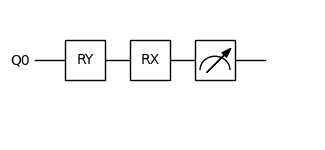

In [4]:
from isqtools.draw import Drawer


dr = Drawer()
dr.plot(qc1.qcis)

## Automatic Differentiation with PyTorch

Compared to the lightweight Autograd library, PyTorch is a powerful and efficient machine learning framework. PyTorch can fully utilize CPU and GPU resources, offering significantly higher computational efficiency.

We highly recommend exploring PyTorch’s basic tutorials as well as its automatic differentiation tutorials to get familiar with its functionality and gradient computation capabilities.

tensor(0.6126, grad_fn=<SelectBackward0>)
tensor([-0.1419, -0.2897])


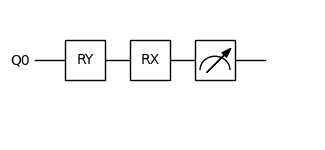

In [5]:
import torch

with tempfile.TemporaryDirectory() as temp_dir:
    temp_dir_path = Path(temp_dir)
    temp_file_path = temp_dir_path / "gradient.isq"
    with open(temp_file_path, "w") as temp_file:
        temp_file.write(FILE_CONTENT)
    torch_backend = TorchBackend()

    qc2 = IsqCircuit(
        file=str(temp_file_path),
        backend=torch_backend,
        sample=False,
    )

    params2 = torch.tensor([0.9, 1.2], requires_grad=True)

    def circuit2(params2):
        return qc2.measure(params=params2)[0]

    result = circuit2(params2)
    result.backward()

    print(result)
    print(params2.grad)
    dr = Drawer()
    dr.plot(qc2.qcis)

## Environment Information

The following versions of software and libraries are used in this tutorial:

In [6]:
import platform
import subprocess
from importlib.metadata import version

print(f"Python version used in this tutorial: {platform.python_version()}")
print(f"Execution environment: {platform.system()} {platform.release()}\n")


isqc_version = subprocess.check_output(
    ["isqc", "-V"], stderr=subprocess.STDOUT, text=True
).strip()
print(f"isqc version: {isqc_version}")

isqtools_version = version("isqtools")
print(f"isqtools version: {isqtools_version}")

numpy_version = version("numpy")
print(f"NumPy version: {isqtools_version}")

autograd_version = version("autograd")
print(f"Autograd version: {autograd_version}")

torch_version = version("torch")
print(f"Torch version: {torch_version}")

Python version used in this tutorial: 3.13.5
Execution environment: Linux 6.12.41

isqc version: isQ Compiler 0.2.5
isqtools version: 1.3.0
NumPy version: 1.3.0
Autograd version: 1.8.0
Torch version: 2.7.1
